In [12]:
import pandas as pd 
import numpy as np 
import pickle 
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt

In [13]:
import torch 
import torch.utils.data as utils
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.nn import LSTM

In [14]:
INPUT_DIM = 2
STATIC_DIM = 68 
BATCH_SIZE = 128
EPOCHS = 50
EARLY_STOPPING = True 
PATIENCE = 5
HIDDEN_SIZE = 128
LEARNING_RATE = 0.0001
OPTIMIZER = torch.optim.RMSprop
MIN_DELTA = 0.00001
FC_SIZE = 256
NUM_LAYERS = 1
DROPOUT = 0.1

### Loading clean data 

In [15]:
infile = open('clean_data.pkl', 'rb')
train, val, test = pickle.load(infile)
infile.close()

X_train, X_static_train, Y_train =  train
X_val, X_static_val, Y_val  = val   
X_test, X_static_test, Y_test = test

### Building Model

In [16]:
class lstm_model(torch.nn.Module): 
    def __init__(self, hidden_size, fc_size, batch_size, fea_size, 
                 fea_static_size, num_layers=1, dropout=0.1): 
        
        super(lstm_model, self).__init__()
        self.hidden_size = hidden_size
        self.fea_size = fea_size 
        self.fc_size = fc_size 
        
        # LSTM layers 
        self.lstm_model = LSTM(fea_size, hidden_size, num_layers=num_layers,
                              dropout=dropout)
        
        # Calculate flattened input 
        flat_size = num_layers * hidden_size 
        flat_size = flat_size #+ fea_static_size
        
        # Fully-Connected layers 
        self.fc1 = torch.nn.Linear(flat_size, fc_size)
        self.fc2 = torch.nn.Linear(fc_size, 1)
    
    def forward(self, input): 
        ts, static = input 
        
        # LSTM 
        _, output = self.lstm_model(ts) # last time-step 
        
        # Flatten 
        output = output[0].transpose(0,1) # bs x num_layers x hidden 
        output = output.flatten(1) # bs x num_layers*hidden
        #output = torch.cat([output, static], dim=1) # bs x num_layers*hidden + static
        
        # FC 
        output = self.fc1(output)
        output = self.fc2(output)
        
        return output

### Create Dataloader

In [17]:
[X_train, X_val, X_test] = [torch.Tensor(tensor) for tensor in [X_train, X_val, X_test]]
[X_static_train, X_static_val, X_static_test] = [torch.Tensor(tensor) for tensor in [X_static_train, X_static_val, X_static_test]]
[Y_train, Y_val, Y_test] = [torch.Tensor(tensor) for tensor in [Y_train, Y_val, Y_test]]

In [18]:
train_dataset = utils.TensorDataset(X_train, X_static_train, Y_train)
train_dataloader = utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [19]:
val_data = ((X_val, X_static_val), Y_val)
test_data = ((X_test, X_static_test), Y_test)

### Loading model 

In [20]:
input_dim = INPUT_DIM
hidden_dim = HIDDEN_SIZE
static_dim = STATIC_DIM

In [21]:
model = lstm_model(hidden_size=HIDDEN_SIZE, fc_size=FC_SIZE,
                   batch_size=BATCH_SIZE, fea_size=INPUT_DIM, 
                   fea_static_size=STATIC_DIM, num_layers=NUM_LAYERS,
                   dropout=DROPOUT)

### Training 

In [22]:
if torch.cuda.is_available(): 
    model.cuda()

In [23]:
loss = torch.nn.MSELoss()

In [24]:
optimizer = OPTIMIZER(model.parameters(), lr = LEARNING_RATE, alpha=.99) #alpha is smoothing constant
use_gpu = torch.cuda.is_available()

In [25]:
losses_epochs_train = []
losses_epochs_valid = []
errors_epochs_valid = []

In [26]:
%%time
# for every epoch
for epoch in range(EPOCHS): 
    losses_epoch_train = []
    #for every batch 
    for data in tqdm(train_dataloader): 
        inputs, statics, predval = data
        
        if inputs.shape[0] != BATCH_SIZE: 
            continue 

        if use_gpu:
            inputs, predval = Variable(inputs.cuda()), Variable(predval.cuda())
        else: 
            inputs, predval = Variable(inputs), Variable(predval)
        
        inputs = inputs.transpose(0,1) # sl x bs x dim_size
        inputs = (inputs, statics)
            
        # Start Training 
        model.zero_grad()
        outputs = model(inputs) #forward pass 
        
        loss_train = loss(outputs.reshape(-1), predval) 
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        losses_epoch_train.append(loss_train.data)

    # Calculate average losses
    avg_losses_epoch_train = sum(losses_epoch_train).cpu().numpy() / float(len(losses_epoch_train))
    losses_epochs_train.append(avg_losses_epoch_train)
    
    print(np.around(avg_losses_epoch_train, decimals=8))
    
    # Validate 
    inputs_val, predval_val = val_data
    inputs_val = (inputs_val[0].transpose(0,1), inputs_val[1]) # sl x bs x dim_size
    
    outputs_val = model(inputs_val)
    loss_val = loss(outputs_val.reshape(-1), predval_val)
    loss_val = float(loss_val.data.cpu())
    errors_val = torch.mean(torch.abs(outputs_val - predval_val))
    
    losses_epochs_valid.append(loss_val)
    errors_epochs_valid.append(float(errors_val))
    # Early Stopping 
    if epoch == 0:
        is_best_model = 1
        best_model = model
        min_loss_epoch_valid = 10000.0
        patient_epoch = 0
        if loss_val < min_loss_epoch_valid:
            min_loss_epoch_valid = loss_val
    else:
        if min_loss_epoch_valid - loss_val > MIN_DELTA:
            is_best_model = 1
            best_model = model
            min_loss_epoch_valid = loss_val 
            patient_epoch = 0
        else:
            is_best_model = 0
            if EARLY_STOPPING: 
                patient_epoch += 1
                if patient_epoch >= PATIENCE:
                    print('Early Stopped at Epoch:', epoch)
                    break
    
    # Print training parameters
    print('Epoch: {}, train_loss: {}, valid_loss: {}, best model: {}'.format( \
                    epoch, \
                    np.around(avg_losses_epoch_train, decimals=8),\
                    np.around(loss_val, decimals=8),\
                    is_best_model))

100%|██████████| 163/163 [00:31<00:00,  5.11it/s]


0.57284298


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 0, train_loss: 0.57284298, valid_loss: 0.35165945, best model: 1


100%|██████████| 163/163 [00:37<00:00,  4.39it/s]


0.2408564


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.2408564, valid_loss: 0.24665329, best model: 1


100%|██████████| 163/163 [00:38<00:00,  4.21it/s]


0.19260114


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 2, train_loss: 0.19260114, valid_loss: 0.17751279, best model: 1


100%|██████████| 163/163 [00:40<00:00,  4.01it/s]


0.16951854


  1%|          | 1/163 [00:00<00:31,  5.09it/s]

Epoch: 3, train_loss: 0.16951854, valid_loss: 0.1643274, best model: 1


100%|██████████| 163/163 [00:39<00:00,  4.15it/s]


0.15511443


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 4, train_loss: 0.15511443, valid_loss: 0.15018618, best model: 1


100%|██████████| 163/163 [00:40<00:00,  4.01it/s]


0.14561879


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 5, train_loss: 0.14561879, valid_loss: 0.14449266, best model: 1


100%|██████████| 163/163 [00:42<00:00,  3.84it/s]


0.1375653


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 6, train_loss: 0.1375653, valid_loss: 0.13158916, best model: 1


100%|██████████| 163/163 [00:53<00:00,  3.07it/s]


0.13016721


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 7, train_loss: 0.13016721, valid_loss: 0.12923674, best model: 1


100%|██████████| 163/163 [00:46<00:00,  3.53it/s]


0.12404516


  1%|          | 1/163 [00:00<00:31,  5.14it/s]

Epoch: 8, train_loss: 0.12404516, valid_loss: 0.11262958, best model: 1


100%|██████████| 163/163 [00:43<00:00,  3.76it/s]


0.11932827


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 9, train_loss: 0.11932827, valid_loss: 0.11352896, best model: 0


100%|██████████| 163/163 [00:43<00:00,  3.74it/s]


0.11579567


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 10, train_loss: 0.11579567, valid_loss: 0.1039746, best model: 1


100%|██████████| 163/163 [00:45<00:00,  3.62it/s]


0.11263844


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 11, train_loss: 0.11263844, valid_loss: 0.11074816, best model: 0


100%|██████████| 163/163 [00:45<00:00,  3.62it/s]


0.11094257


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 12, train_loss: 0.11094257, valid_loss: 0.10288805, best model: 1


100%|██████████| 163/163 [00:45<00:00,  3.62it/s]


0.10955427


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 13, train_loss: 0.10955427, valid_loss: 0.10215385, best model: 1


100%|██████████| 163/163 [00:44<00:00,  3.65it/s]


0.10729326


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 14, train_loss: 0.10729326, valid_loss: 0.09873623, best model: 1


100%|██████████| 163/163 [00:44<00:00,  3.68it/s]


0.10626008


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 15, train_loss: 0.10626008, valid_loss: 0.09453588, best model: 1


100%|██████████| 163/163 [00:44<00:00,  3.67it/s]


0.10514603


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 16, train_loss: 0.10514603, valid_loss: 0.10186413, best model: 0


100%|██████████| 163/163 [00:45<00:00,  3.58it/s]


0.10351733


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 17, train_loss: 0.10351733, valid_loss: 0.097314, best model: 0


100%|██████████| 163/163 [00:45<00:00,  3.56it/s]


0.10295174


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 18, train_loss: 0.10295174, valid_loss: 0.09724384, best model: 0


100%|██████████| 163/163 [00:47<00:00,  3.46it/s]


0.10152236


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 19, train_loss: 0.10152236, valid_loss: 0.09173323, best model: 1


100%|██████████| 163/163 [00:48<00:00,  3.35it/s]


0.09949896


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 20, train_loss: 0.09949896, valid_loss: 0.10336446, best model: 0


100%|██████████| 163/163 [00:44<00:00,  3.65it/s]


0.09792564


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 21, train_loss: 0.09792564, valid_loss: 0.08986442, best model: 1


100%|██████████| 163/163 [00:45<00:00,  3.58it/s]


0.09731797


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 22, train_loss: 0.09731797, valid_loss: 0.10982755, best model: 0


100%|██████████| 163/163 [00:46<00:00,  3.50it/s]


0.09628769


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 23, train_loss: 0.09628769, valid_loss: 0.08347684, best model: 1


100%|██████████| 163/163 [00:44<00:00,  3.65it/s]


0.09502294


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 24, train_loss: 0.09502294, valid_loss: 0.08891317, best model: 0


100%|██████████| 163/163 [00:48<00:00,  3.37it/s]


0.09423271


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 25, train_loss: 0.09423271, valid_loss: 0.08407894, best model: 0


100%|██████████| 163/163 [00:46<00:00,  3.49it/s]


0.09301341


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 26, train_loss: 0.09301341, valid_loss: 0.07901996, best model: 1


100%|██████████| 163/163 [00:46<00:00,  3.49it/s]


0.0929661


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 27, train_loss: 0.0929661, valid_loss: 0.08038917, best model: 0


100%|██████████| 163/163 [00:50<00:00,  3.25it/s]


0.09228827


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 28, train_loss: 0.09228827, valid_loss: 0.0812571, best model: 0


100%|██████████| 163/163 [00:45<00:00,  3.56it/s]


0.09098327


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 29, train_loss: 0.09098327, valid_loss: 0.0756657, best model: 1


100%|██████████| 163/163 [00:43<00:00,  3.74it/s]


0.0899025


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 30, train_loss: 0.0899025, valid_loss: 0.07714482, best model: 0


100%|██████████| 163/163 [00:44<00:00,  3.63it/s]


0.0902449


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 31, train_loss: 0.0902449, valid_loss: 0.07604001, best model: 0


100%|██████████| 163/163 [00:46<00:00,  3.53it/s]


0.08881707


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 32, train_loss: 0.08881707, valid_loss: 0.08992484, best model: 0


100%|██████████| 163/163 [00:44<00:00,  3.67it/s]


0.08823139


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 33, train_loss: 0.08823139, valid_loss: 0.08067901, best model: 0


100%|██████████| 163/163 [00:45<00:00,  3.55it/s]


0.08773499


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 34, train_loss: 0.08773499, valid_loss: 0.07499936, best model: 1


100%|██████████| 163/163 [00:47<00:00,  3.46it/s]


0.08649824


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 35, train_loss: 0.08649824, valid_loss: 0.07477245, best model: 1


100%|██████████| 163/163 [00:44<00:00,  3.68it/s]


0.0856125


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 36, train_loss: 0.0856125, valid_loss: 0.07483007, best model: 0


100%|██████████| 163/163 [00:47<00:00,  3.44it/s]


0.08567893


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 37, train_loss: 0.08567893, valid_loss: 0.07290282, best model: 1


100%|██████████| 163/163 [00:46<00:00,  3.49it/s]


0.08436892


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 38, train_loss: 0.08436892, valid_loss: 0.07163592, best model: 1


100%|██████████| 163/163 [00:44<00:00,  3.67it/s]


0.08393707


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 39, train_loss: 0.08393707, valid_loss: 0.07359536, best model: 0


100%|██████████| 163/163 [00:46<00:00,  3.50it/s]


0.08384851


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 40, train_loss: 0.08384851, valid_loss: 0.0722229, best model: 0


100%|██████████| 163/163 [00:46<00:00,  3.53it/s]


0.08312609


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 41, train_loss: 0.08312609, valid_loss: 0.0712651, best model: 1


100%|██████████| 163/163 [00:46<00:00,  3.52it/s]


0.08269244


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 42, train_loss: 0.08269244, valid_loss: 0.07383776, best model: 0


100%|██████████| 163/163 [00:45<00:00,  3.56it/s]


0.08185307


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 43, train_loss: 0.08185307, valid_loss: 0.0734956, best model: 0


100%|██████████| 163/163 [00:48<00:00,  3.34it/s]


0.08122501


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 44, train_loss: 0.08122501, valid_loss: 0.07263908, best model: 0


100%|██████████| 163/163 [00:48<00:00,  3.38it/s]


0.08097598


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 45, train_loss: 0.08097598, valid_loss: 0.06981494, best model: 1


100%|██████████| 163/163 [00:44<00:00,  3.63it/s]


0.07967929


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 46, train_loss: 0.07967929, valid_loss: 0.07301826, best model: 0


100%|██████████| 163/163 [00:45<00:00,  3.62it/s]


0.07950342


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 47, train_loss: 0.07950342, valid_loss: 0.06952661, best model: 1


100%|██████████| 163/163 [00:46<00:00,  3.53it/s]


0.07845881


  0%|          | 0/163 [00:00<?, ?it/s]

Epoch: 48, train_loss: 0.07845881, valid_loss: 0.06899749, best model: 1


100%|██████████| 163/163 [00:47<00:00,  3.44it/s]


0.07818364
Epoch: 49, train_loss: 0.07818364, valid_loss: 0.07055765, best model: 0
CPU times: user 2h 46min 25s, sys: 1h 34min 11s, total: 4h 20min 37s
Wall time: 42min 7s


In [62]:
torch.save(model, 'LSTM_simple.pt')

/home/kristoforus/miniconda3/envs/deeplearning/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type lstm_model. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


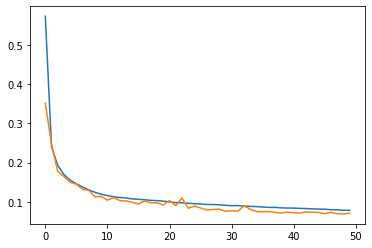

In [27]:
plt.plot(losses_epochs_train)
plt.plot(losses_epochs_valid)

### Testing 

In [28]:
inputs_test, predval_test = test_data
inputs_test = (inputs_test[0].transpose(0,1), inputs_test[1]) # sl x bs x dim_size

In [29]:
outputs_test = model(inputs_test)

In [30]:
test_loss = loss(outputs_test.reshape(-1), predval_test)

In [32]:
test_loss

tensor(0.0886, grad_fn=<MseLossBackward>)

MSE LOSS =  0.0886

In [33]:
predval.shape

torch.Size([128])

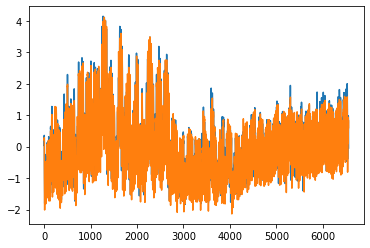

In [35]:
plt.plot(predval_test)
plt.plot(outputs_test.reshape(-1).data)

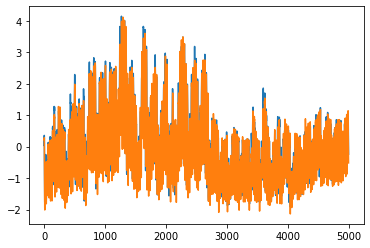

In [36]:
plt.plot(predval_test[:5000])
plt.plot(outputs_test.reshape(-1).data[:5000])

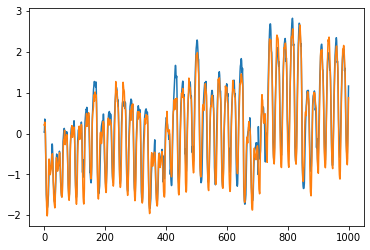

In [37]:
plt.plot(predval_test[:1000])
plt.plot(outputs_test.reshape(-1).data[:1000])

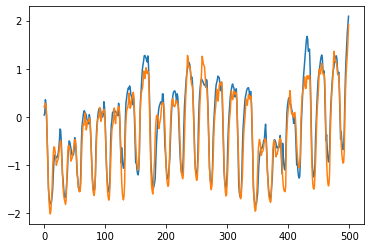

In [38]:
plt.plot(predval_test[:500])
plt.plot(outputs_test.reshape(-1).data[:500])

In [39]:
now = 0
def next_graph():
    print(now)
    plt.plot(predval_test[now:now + 200])
    plt.plot(outputs_test.reshape(-1).data[now:now + 200])
    return(now + 200)

def prev_graph():
    print(now-200)
    plt.plot(predval_test[now - 200:now ])
    plt.plot(outputs_test.reshape(-1).data[now-200:now])
    return(now - 200)

3400


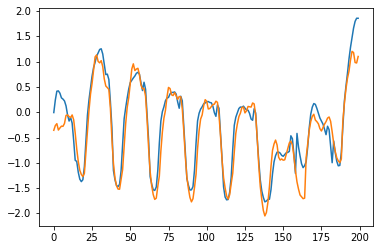

In [61]:
now = next_graph()

1600


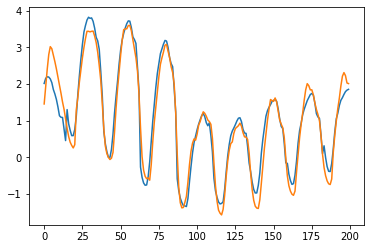

In [51]:
now = prev_graph()